- 프로젝트명 : 물순환시스템 설비예지보전
- 분석자 : 백종환
- 일자 : 2023년 8월 2일 ~ 8월 8일

# Water Circulation System 설비 예지 보전
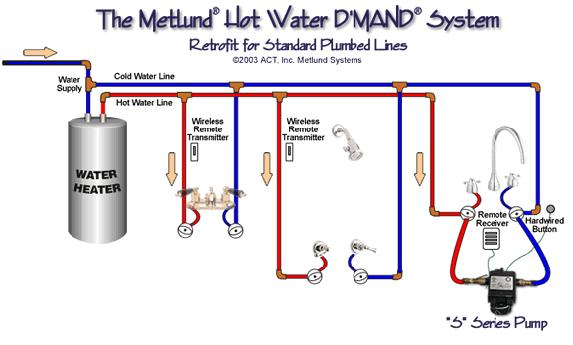

- 문제이해하기, 데이터 훑어보기
- 문제해결 프로세스 정의 : 문제해결 기획
- 수행내용
    - Data 전처리 및 EDA
    - 시계열 센서 데이터 분석
    - 이상탐지 모델링

## 문제이해하기, 데이터 훑어보기

### 가상 시나리오  
- A사는 Water Circulation System을 운영하는 유지보수 업체다.  
- 사업이 확장됨에 따라 많은 고객을 대상으로 Water Circulation System을 설치하고 있다.  
- Water Circulation System은 한번 고장이 나면 심각한 피해를 발생시키기 때문에 사전에 이상징후를 발견하고 조치를 통해 고장을 사전에 방지하는 활동이 매우 중요하다.  
- A사는 사업이 확장됨에 따라 관리해야할 업체들이 증가하고 있고, 고장이 발생한다면 사업에 큰 지장을 초래하기 때문에 이상진단 모델을 통해서 사전 유지보수 활동을 전개해나가고자 한다.

### 데이터 구성

* 시계열 센서 데이터 (Water Circulation System)
* 데이터 명세  

|Column|Description|
|:---|:---|
|datetime|시간|
|Accelerometer1RMS|진동 가속도1|
|Accelerometer2RMS|진동 가속도2|
|Current |전기모터 암페어(Ampere)|
|Pressure|워터 펌프 후 루프의 압력(Bar) |
|Temperature|엔진의 온도(섭씨 온도)|
|Thermocouple|순환 루프에서 유체의 온도(섭씨 온도)|
|Voltage|전기 모터의 전압(Volt)|
|Volume Flow RateRMS|루프 내부의 유체의 순환 유량(Liter/min)|
|anomaly|이상여부|
|changepoint|변경점 여부|

    - 와우 "이상여부"가 있다. label 존재 !!

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)

# 경고메시지 무시할 때
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 읽어오기, 구분자가 ,가 아니고 ; 이네요.
df = pd.read_csv("물순환설비데이터.csv", sep=";")

In [3]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')
data_drop = df.drop('2020-03-09 16:35:27', axis=0)
data_re = data_drop.resample('1s').mean()


## 문제해결 프로세스 기획 (데이터분석 전에 반드시 수행되어야 하는 단계)

1) 문제정의
- 사업 확장으로 인한 관리 Point 증가에 따른 운영 및 유지보수 인력 부족
- Water Circulation System 고장으로 인한 리스크 발생 우려

2) 기대효과 : 기대효과 낮으면 굳이 고급인력을 활용해서 데이터분석을 할 필요가 없다.
- 이상진단 시스템을 통한 사전 유지보수를 통해 고장 발생으로 인한 리스크(비용, 신뢰도 등등) 감소
- 이상진단 솔루션 제공(ex. AI 기반 이상탐지 알고리즘)을 통한 추가 고객 유치
- 기존 고객의 충성도 증가

3) 해결방안
- 모델링을 통한 이상진단 시스템 구축 및 운영
    - Data 전처리 및 EDA 
    - 시계열 센서 데이터 분석 
    - 이상탐지 모델링 

4) 성과측정 (모델의 성능인 정확도 90%? 이것은 성과가 아님. 문제정의에 맞는 성과가 측정되어야 함)
- 이상진단 시스템 활용 전/후 고장 발생률 비교 (Main KPI)
- 이상진단 솔루션 운영 전/후 신규 고객 증가 및 기존 고객 만족도 조사

5) 현업적용을 위해서는 ...
- 이상진단 모델 생성
- 실시간 데이터 수집 체계 구축
- 실시간 이상 진단 모델 실행 및 결과값 출력
- 결과값 기반 모니터링 시스템(이상진단 대시보드) 운영


## Data 전처리 및 EDA

### Data 전처리  
- 수집된 데이터의 기본 정보들을 확인해서 데이터에 문제가 있는지 확인하는 단계  

  (1) Data shape(모양, row/column 개수) 확인
  
  (2) Data type 확인 : 숫자, 문자 등 확인, '123' : 이건 문자죠 !
  
  (3) Null(NaN)값 확인 (※ 빈 값의 Data)
  
  (4) Outlier 확인 (※ 정상적인 범주를 벗어난 Data)  - 이상탐지에서는 outlier를 찾는 거라 제거하면 안되지만, 그런데 전압데이터인데 음수라면 제거해야 함.

In [4]:
# Data 형태 
data_re.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1201 entries, 2020-03-09 16:16:30 to 2020-03-09 16:36:30
Freq: S
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Accelerometer1RMS    1062 non-null   float64
 1   Accelerometer2RMS    1062 non-null   float64
 2   Current              1062 non-null   float64
 3   Pressure             1062 non-null   float64
 4   Temperature          1062 non-null   float64
 5   Thermocouple         1062 non-null   float64
 6   Voltage              1062 non-null   float64
 7   Volume Flow RateRMS  1062 non-null   float64
 8   anomaly              1062 non-null   float64
 9   changepoint          1062 non-null   float64
dtypes: float64(10)
memory usage: 103.2 KB


In [5]:
# Null 값 확인
data_re.isna().sum()

Accelerometer1RMS      139
Accelerometer2RMS      139
Current                139
Pressure               139
Temperature            139
Thermocouple           139
Voltage                139
Volume Flow RateRMS    139
anomaly                139
changepoint            139
dtype: int64

In [6]:
# Outlier 확인, describe()는 수치형 데이터에 대해서만 동작함.
data_re.describe()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
count,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000,1062.000000
mean,0.027663,0.040037,0.977218,0.048227,67.895683,24.265134,230.140779,31.472681,0.313559,0.003766
std,0.000333,0.001086,0.269601,0.270622,0.695327,0.021547,11.241006,1.315088,0.464158,0.061285
min,0.026455,0.036972,0.394058,-0.929070,66.201900,24.217000,203.658000,28.040000,0.000000,0.000000
25%,0.027434,0.039274,0.753367,0.054711,67.413050,24.253025,223.638750,31.038975,0.000000,0.000000
50%,0.027674,0.040097,1.002545,0.054711,67.955650,24.267300,230.644000,32.000000,0.000000,0.000000
75%,0.027892,0.040829,1.193910,0.054711,68.515700,24.277475,236.961500,32.038900,1.000000,0.000000
max,0.028554,0.043122,1.546680,1.038490,69.098200,24.332300,254.125000,33.000000,1.000000,1.000000


In [7]:
# Outlier 확인(음수값), pressure
data_re[data_re['Pressure'] < 0].head()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 16:16:33,0.027625,0.039366,0.566279,-0.273216,67.7918,24.3323,229.709,32.0000,0.0,0.0
2020-03-09 16:16:37,0.027832,0.039037,0.785302,-0.273216,68.0941,24.3156,206.719,32.9627,0.0,0.0
2020-03-09 16:16:41,0.027365,0.040159,1.214350,-0.273216,68.0307,24.3237,217.917,32.0000,0.0,0.0
2020-03-09 16:16:43,0.027701,0.037805,1.127500,-0.273216,67.9973,24.3158,227.584,32.0000,0.0,0.0
2020-03-09 16:16:44,0.027992,0.038999,1.100170,-0.273216,67.8537,24.3254,229.871,32.0000,0.0,0.0


### Data EDA(탐색적 데이터 분석)

* 데이터 특성 파악을 위한 초기 탐색
* anomaly와 change point를 타겟변수로 보고 구분해서 데이터를 탐색

- Target Ratio 확인

In [8]:
# Anomaly 및 Change Point 확인 (1) - 'anomaly'
# Target ratio(%) 확인
print('anomaly ratio : ', len(data_re[data_re['anomaly'] == 1]) / len(data_re[data_re['anomaly'] == 0]) * 100, '%')

anomaly ratio :  45.67901234567901 %


In [9]:
# Anomaly 및 Change Point 확인 (2) - 'chagepoint'
# Target ratio(%) 확인
print('changepoint 0 : ', len(data_re[data_re['changepoint'] == 1]) / len(data_re[data_re['changepoint'] == 0]) * 100, '%')

changepoint 0 :  0.3780718336483932 %


In [10]:
# data split
# df_anomaly, df_normal, df_change 등으로 데이터를 구분하여 만들어보자.
df_anomaly = data_re[data_re['anomaly'] == 1]
df_normal = data_re[data_re['anomaly'] == 0]
df_change =data_re['changepoint']

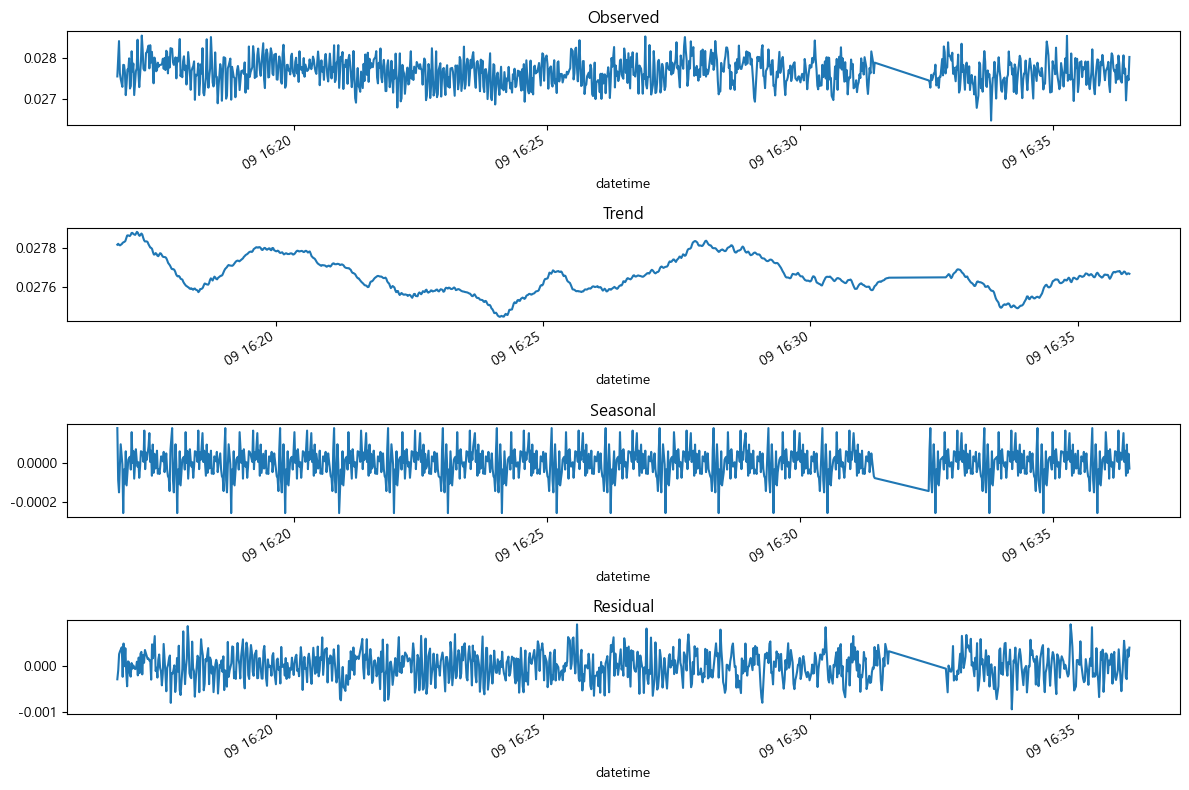

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

# STL 분해를 위해 선택한 'Accelerometer1RMS' 컬럼
series = df['Accelerometer1RMS']

# 계절성 분해 (계절성 주기를 60으로 설정)
result = seasonal_decompose(series, period=60, model='additive')

# 결과 시각화
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12, 8))
result.observed.plot(ax=ax1, title="Observed")
result.trend.plot(ax=ax2, title="Trend")
result.seasonal.plot(ax=ax3, title="Seasonal")
result.resid.plot(ax=ax4, title="Residual")
plt.tight_layout()
plt.show()

## 시계열 센서 데이터 분석

* 시계열 센서 데이터 시각화 및 이상(abnormal) 데이터 탐색
* Contextual Anomaly Detection vs Point Anomaly Detection

### 센서별 시각화 (Time-series)
---
- 시계열 센서 데이터는 시간순서에 따른 데이터이므로 시각화 필수
- plt.plot() 활용

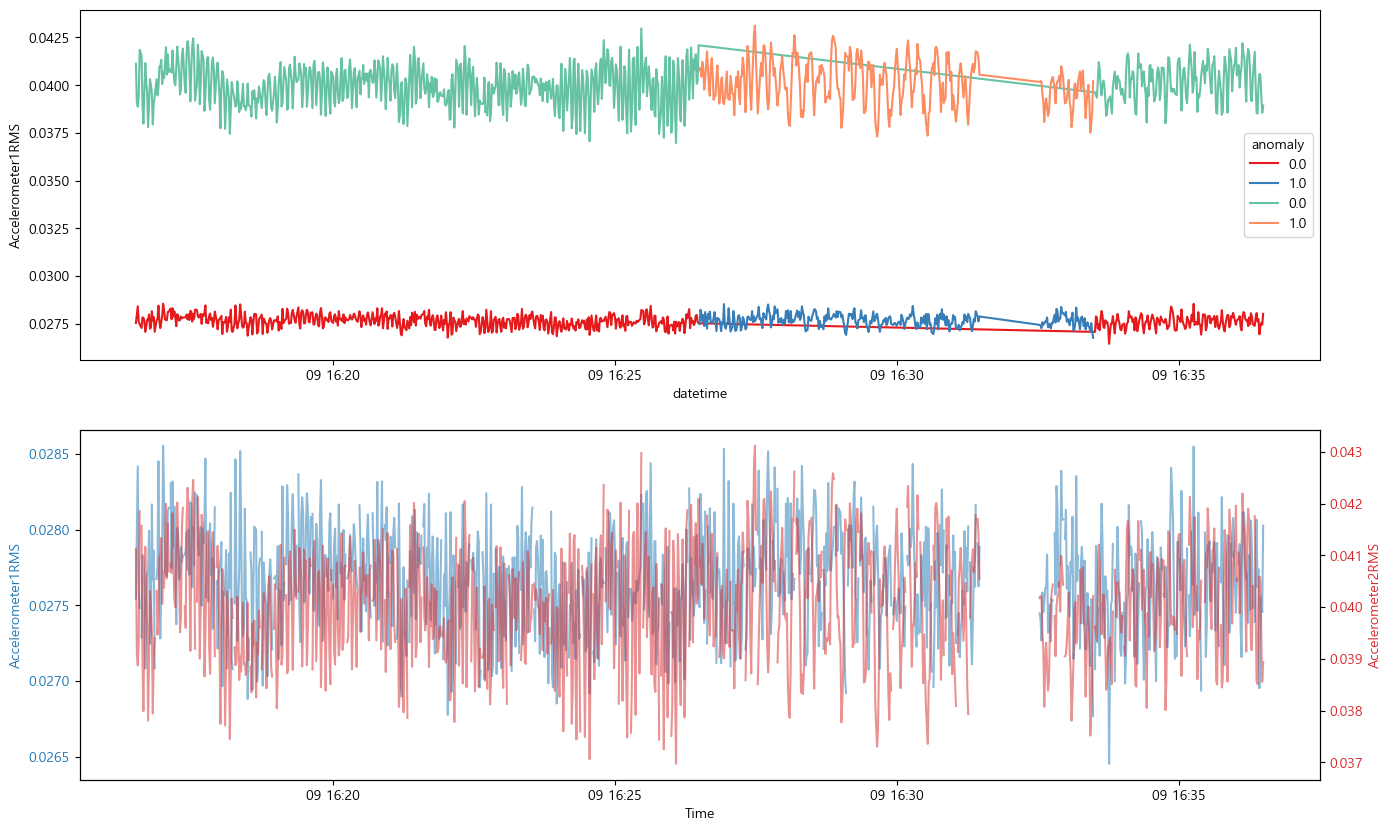

In [12]:
fig, ax1 = plt.subplots(2, 1, figsize=(16, 10))

# 왼쪽 y축을 기준으로 seaborn의 lineplot 그리기
sns.lineplot(data=data_re, x=data_re.index, y='Accelerometer1RMS', palette='Set1', hue='anomaly', ax=ax1[0])
sns.lineplot(data=data_re, x=data_re.index, y='Accelerometer2RMS', palette='Set2', hue='anomaly', ax=ax1[0])

# 왼쪽 y축을 기준으로 라인 그래프 그리기
ax1[1].plot(data_re.index, data_re['Accelerometer1RMS'], color='tab:blue', alpha=0.5)
ax1[1].set_xlabel('Time')
ax1[1].set_ylabel('Accelerometer1RMS', color='tab:blue')
ax1[1].tick_params(axis='y', labelcolor='tab:blue')

# 오른쪽 y축을 기준으로 라인 그래프 그리기
ax2 = ax1[1].twinx()
ax2.plot(data_re.index, data_re['Accelerometer2RMS'], color='tab:red', alpha=0.5)
ax2.set_ylabel('Accelerometer2RMS', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.show()


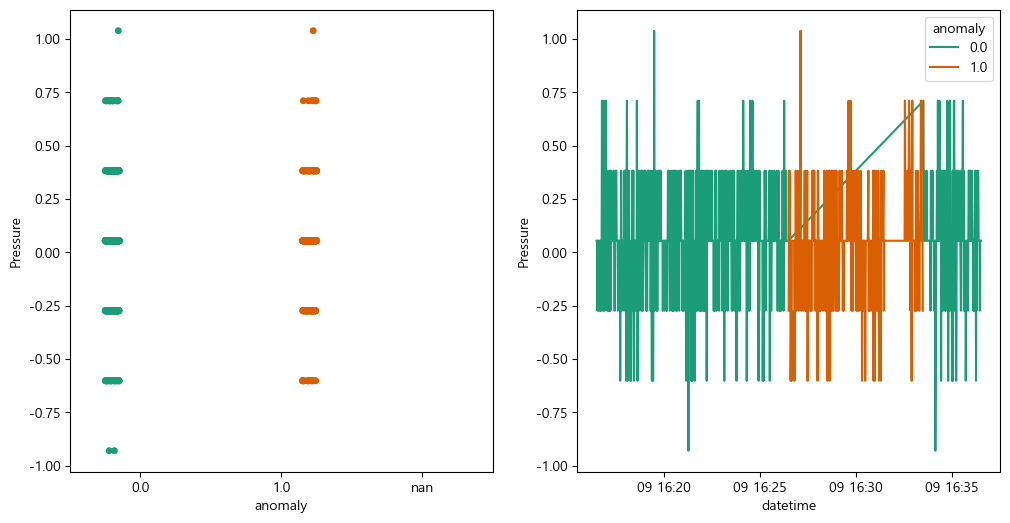

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.stripplot(data=data_re, x='anomaly', y='Pressure', jitter=True, palette='Dark2', dodge=True, ax=ax[0])
sns.lineplot(data=data_re, x=data_re.index, y='Pressure', ax=ax[1], hue='anomaly', palette='Dark2')
plt.show()

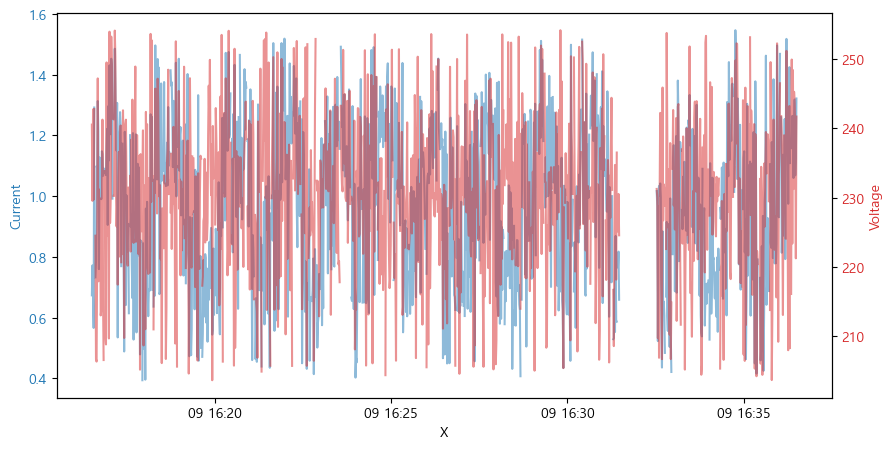

In [14]:
fig, ax1 = plt.subplots(figsize=(10, 5))
# 왼쪽 y축을 기준으로 라인 그래프 그리기
ax1.plot(data_re.index, data_re['Current'], color='tab:blue', alpha=0.5)
ax1.set_xlabel('X')
ax1.set_ylabel('Current', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 오른쪽 y축을 기준으로 라인 그래프 그리기
ax2 = ax1.twinx()
ax2.plot(data_re.index, data_re['Voltage'], color='tab:red', alpha=0.5)
ax2.set_ylabel('Voltage', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.show()

<Figure size 640x480 with 0 Axes>

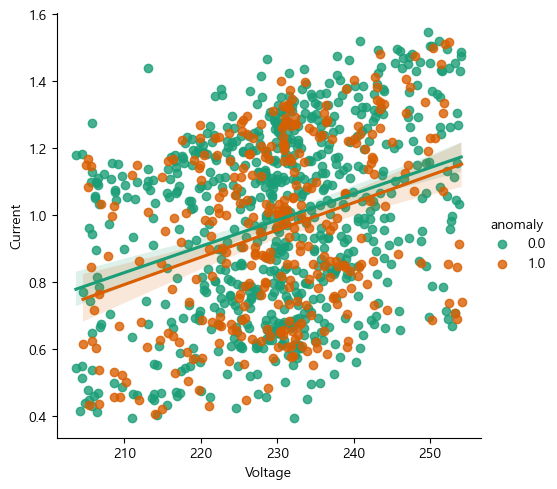

In [15]:
plt.figure()
sns.lmplot(data=data_re, x='Voltage', y='Current', hue='anomaly', palette='Dark2')
plt.show()

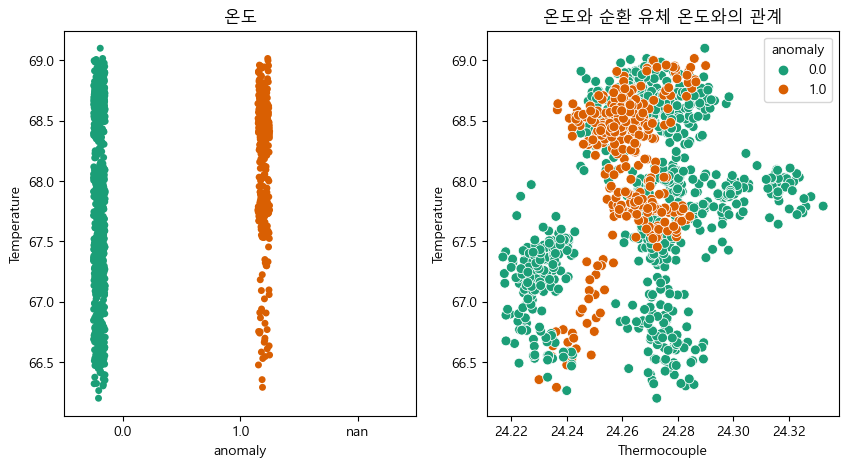

In [16]:
fig, ax = plt.subplots(1,2 ,figsize=(10, 5))
sns.stripplot(data=data_re, x='anomaly', y='Temperature', jitter=True, dodge=True, ax=ax[0], palette='Dark2')
ax[0].set_title('온도')
sns.scatterplot(data=data_re, x='Thermocouple', y='Temperature', hue='anomaly', s=50, ax=ax[1], palette='Dark2')
ax[1].set_title('온도와 순환 유체 온도와의 관계')
plt.show()

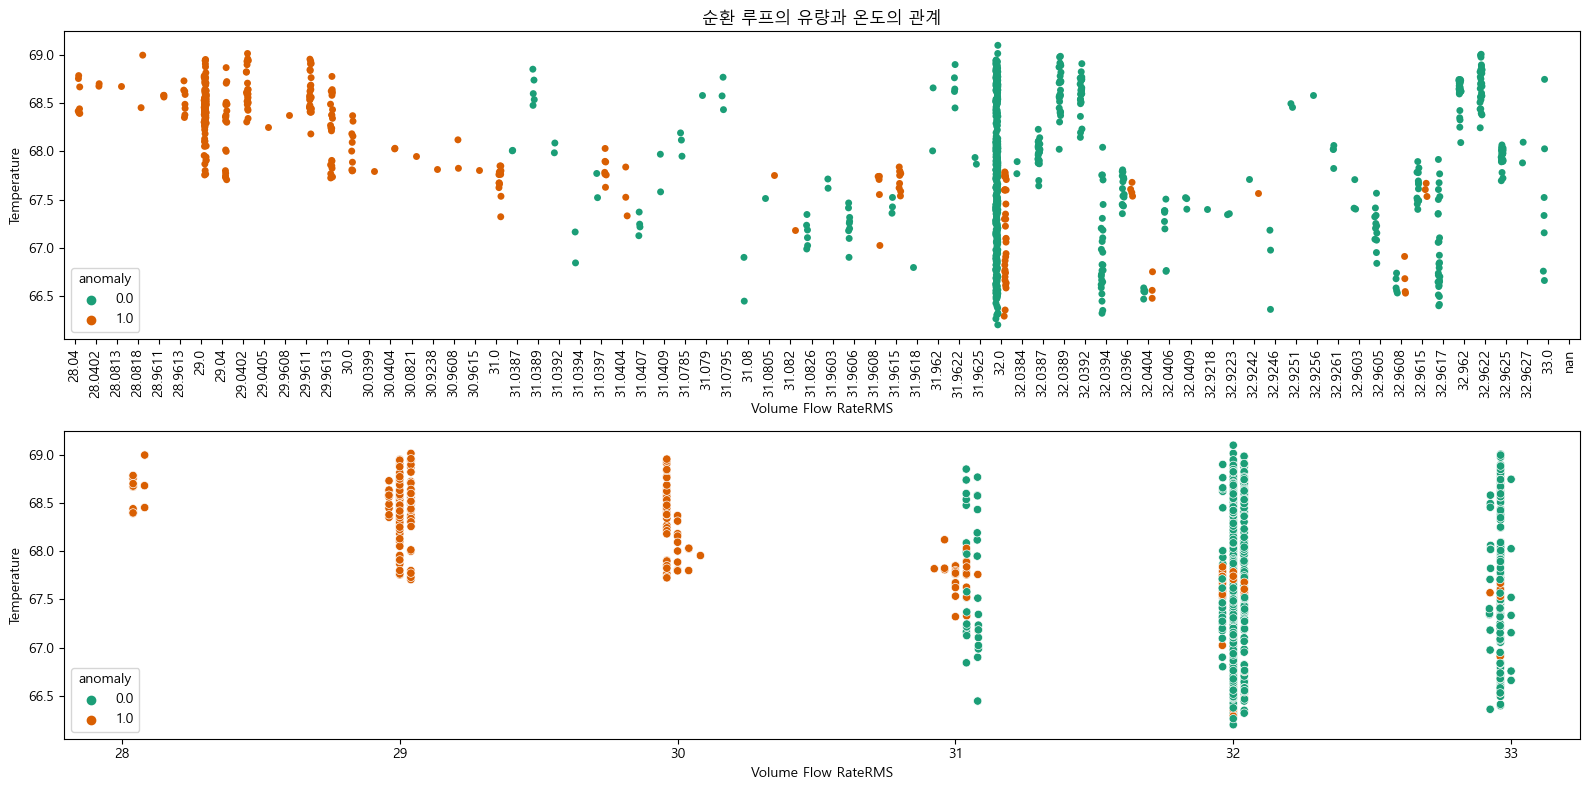

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8))
sns.stripplot(data=data_re, x='Volume Flow RateRMS', y='Temperature', hue='anomaly', jitter=True, dodge=True, palette='Dark2', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)  # 수정된 부분
ax[0].set_title('순환 루프의 유량과 온도의 관계')
sns.scatterplot(data=data_re, x='Volume Flow RateRMS', y='Temperature', hue='anomaly', palette='Dark2', ax=ax[1])
plt.tight_layout()
plt.show()

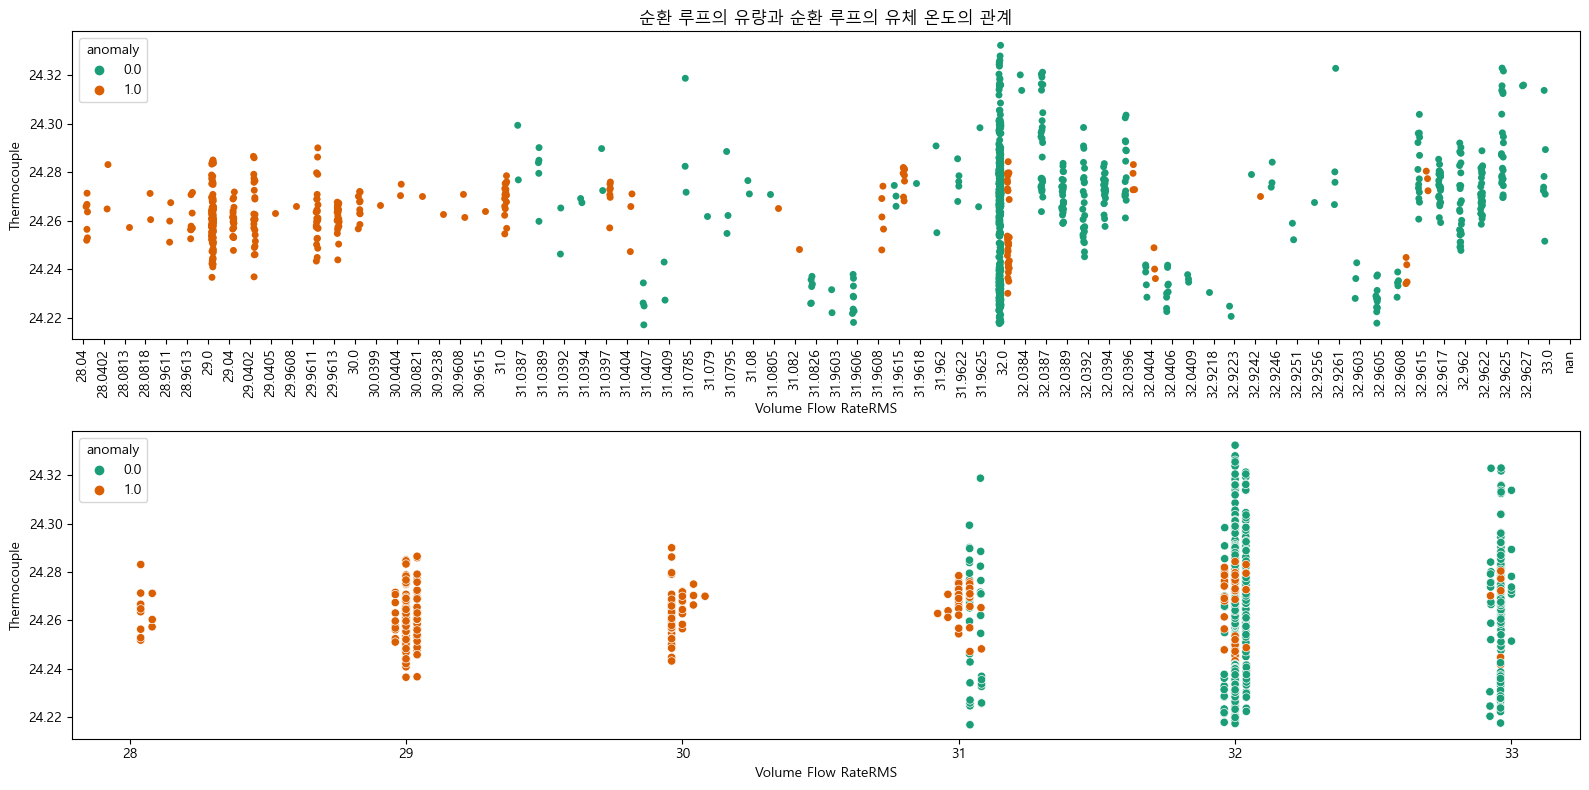

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8))
sns.stripplot(data=data_re, x='Volume Flow RateRMS', y='Thermocouple', hue='anomaly', jitter=True, dodge=True, palette='Dark2', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)  # 수정된 부분
ax[0].set_title('순환 루프의 유량과 순환 루프의 유체 온도의 관계')
sns.scatterplot(data=data_re, x='Volume Flow RateRMS', y='Thermocouple', hue='anomaly', palette='Dark2', ax=ax[1])
plt.tight_layout()
plt.show()

### 센서별 분포 (Distribution)
---
- 각 센서데이터의 분포를 보고 분류가능한지 확인해볼려고
- seaborn.displot() 활용

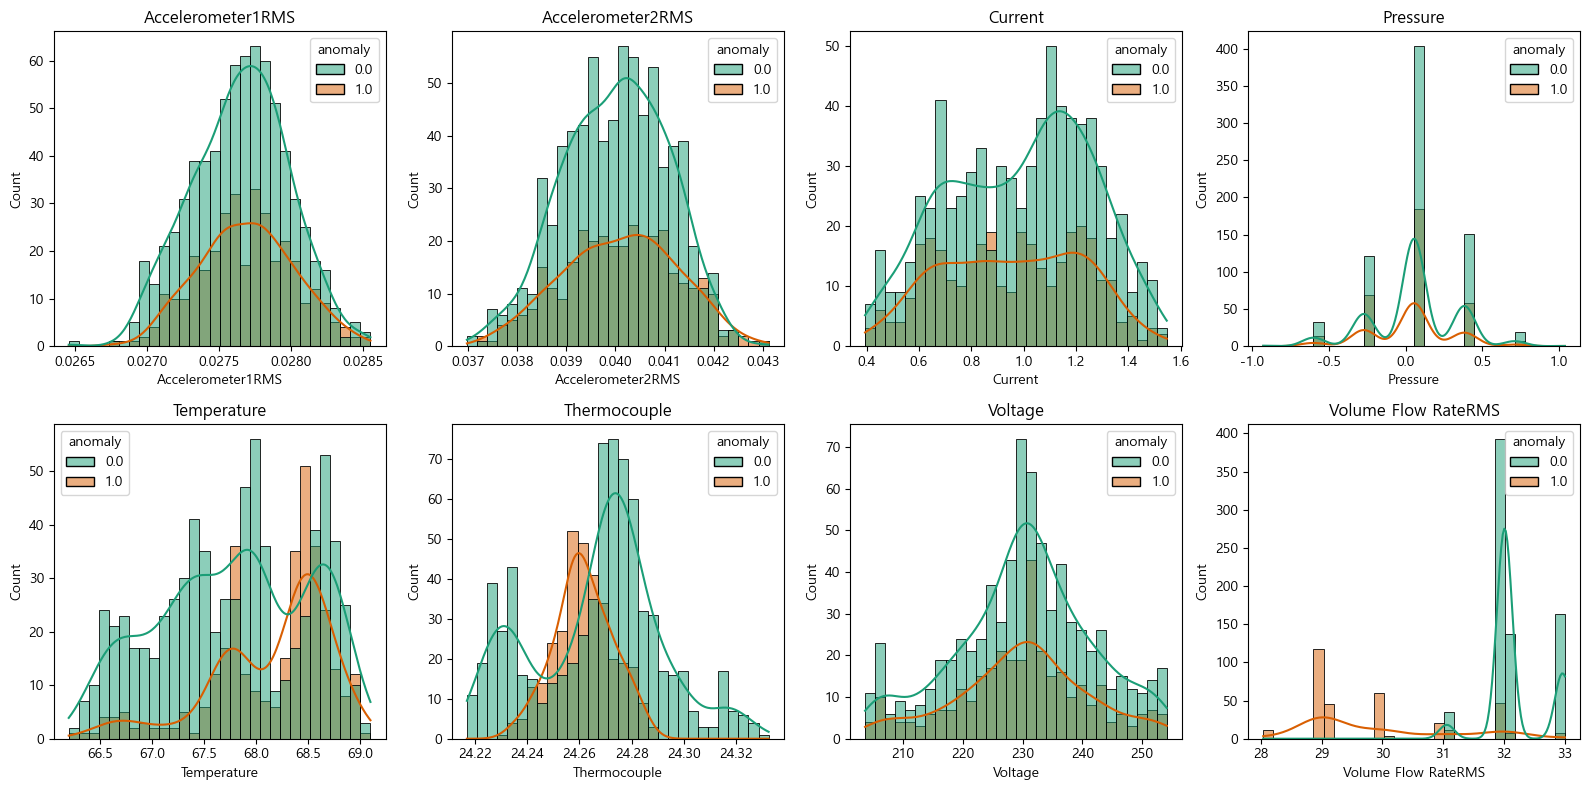

In [19]:

plt.figure(figsize=(16,8))
for i in range(len(data_re.columns[:-2])):
    plt.subplot(2, 4, i+1)
    sns.histplot(data=data_re, x=data_re.columns[i], kde=True, hue='anomaly', bins=30, palette='Dark2')
    plt.title(data_re.columns[i])
plt.tight_layout()
plt.show()

### 상관관계 분석 (Correlation)
---
- 상관관계분석을 통해 anomaly, normal 데이터의 분류 가능성 확인
- corr(), heatmap() 활용

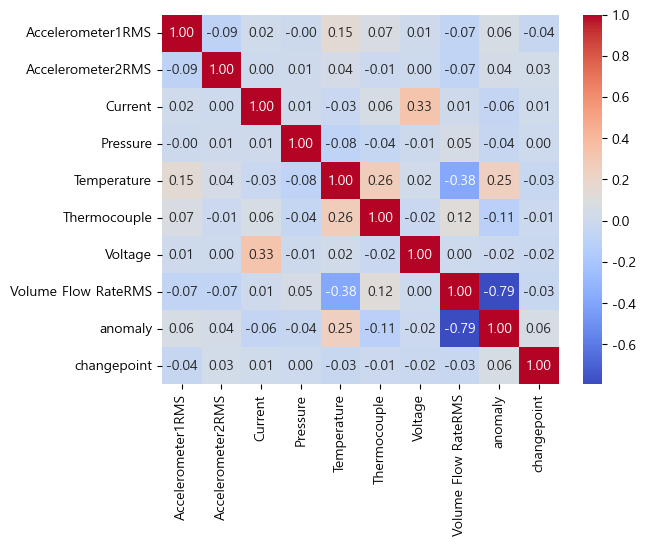

In [20]:
cor = data_re.corr()
plt.figure()
sns.heatmap(data=cor, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

## 이상탐지 모델링

### Model Selection
---
- 변수의 시간에 따른 이상탐지 보다는 변수간 관계에 따른 이상탐지 수행 필요

* Isolation Forest - 기본적으로 사용했으면 합니다. 성능이 괜찮아요. 
* 추가로 어떤 이상탐지 알고리즘을 써보세요

### 모델링을 위한 데이터 준비
---
* 모델링을 수행하기 위해 Feature(X)와 예측하고자하는 값인 y로 데이터를 나눔
* 학습과 예측을 위한 Train / Test set 분할
* Train/Test 분할시 anomaly 데이터가 일정하게 포함되도록 하는 것이 필수, 확인도 필요

In [21]:
from sklearn.model_selection import train_test_split

data_drop['anomaly'] = data_drop['anomaly'].bfill()

# anomaly가 0인 데이터와 그렇지 않은 데이터로 분리
zero_df = data_drop[data_drop['anomaly'] == 0]
nonzero_df = data_drop[data_drop['anomaly'] != 0]

# anomaly가 0인 데이터를 훈련 데이터와 테스트 데이터로 분리
train_zero_df, test_zero_df = train_test_split(zero_df, test_size=0.2, random_state=42)

# 훈련 데이터 생성
X_train = train_zero_df.drop('anomaly', axis=1).interpolate(method='linear')
y_train = train_zero_df['anomaly']

# 테스트 데이터 생성 (anomaly가 0인 데이터와 그렇지 않은 데이터 모두 포함)
test_df = pd.concat([test_zero_df, nonzero_df], ignore_index=True)
X_test = test_df.drop('anomaly', axis=1).interpolate(method='linear')
y_test = test_df['anomaly']

from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X_train_sc = std.fit_transform(X_train)
X_test_sc = std.transform(X_test)

In [22]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((583, 9), (583,), (479, 9), (479,))

### 모델 학습 및 평가
---
- IsolationForest
- 성능평가(과적합되는지도 확인해보세요)
- 성능중에서 무엇을 중점적으로 보아야 할까요? Accuracty(정확도), Precision(정밀도), Recall(재현율) ? 
- sklearn.metrics의 classification_report() 활용

In [23]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay, confusion_matrix, roc_curve, f1_score, roc_auc_score

def verification_train(y, predict):
    # 성능 평가
    print("Train Accuracy  : ", accuracy_score(y, predict))
    print('f1 score        : ', f1_score(y, predict))
    print('Recall Score    : ', recall_score(y, predict))
    print('precision score : ', precision_score(y, predict))
    print('confusion matrix : ------------------\n', confusion_matrix(y, predict))
    print("\n         --------- Test Classification Report --------")
    print(classification_report(y, predict))

    # 혼동 행렬 시각화
    plt.figure()
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y, predict), display_labels=['정상', '이상']).plot(cmap='Blues')
    plt.show()

def verification_test(y, predict):
    # 성능 평가
    print("Train Accuracy  : ", accuracy_score(y, predict))
    print('f1 score        : ', f1_score(y, predict))
    print('Recall Score    : ', recall_score(y, predict))
    print('precision score : ', precision_score(y, predict))
    print('confusion matrix : ------------------\n', confusion_matrix(y, predict))
    print("\n         --------- Test Classification Report --------")
    print(classification_report(y, predict))

    # 혼동 행렬 시각화
    plt.figure()
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y, predict), display_labels=['정상', '이상']).plot(cmap='Blues')
    plt.show()

# def roc_auc(y, predict):
    fpr, tpr, _ = roc_curve(y, predict)
    auc = roc_auc_score(y, predict)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], linestyle='--')
    plt.text(0.5, 0.3, f'AUC = {auc:.4f}', fontsize=20)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

Train Accuracy  :  0.7873070325900514
f1 score        :  0.0
Recall Score    :  0.0
precision score :  0.0
confusion matrix : ------------------
 [[459 124]
 [  0   0]]

         --------- Test Classification Report --------
              precision    recall  f1-score   support

         0.0       1.00      0.79      0.88       583
         1.0       0.00      0.00      0.00         0

    accuracy                           0.79       583
   macro avg       0.50      0.39      0.44       583
weighted avg       1.00      0.79      0.88       583



<Figure size 640x480 with 0 Axes>

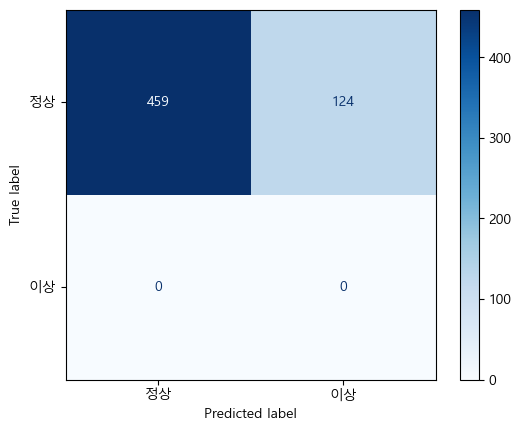

In [24]:
from sklearn.ensemble import IsolationForest

# IsolationForest 모델 학습 (anomaly는 -1, normal은 1로 표현되므로, y 값을 조정)
model = IsolationForest(contamination='auto', max_features=0.1, max_samples=200, n_estimators=300, random_state=42)
model.fit(X_train)

# 예측 (-1, 1 값을 1, 0으로 변환)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
y_pred_train = [1 if pred == -1 else 0 for pred in pred_train]
y_pred_test = [1 if pred == -1 else 0 for pred in pred_test]

verification_train(y_train, y_pred_train)

- OC-SVM

Train Accuracy  :  0.9451114922813036
f1 score        :  0.0
Recall Score    :  0.0
precision score :  0.0
confusion matrix : ------------------
 [[551  32]
 [  0   0]]

         --------- Test Classification Report --------
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97       583
         1.0       0.00      0.00      0.00         0

    accuracy                           0.95       583
   macro avg       0.50      0.47      0.49       583
weighted avg       1.00      0.95      0.97       583



<Figure size 640x480 with 0 Axes>

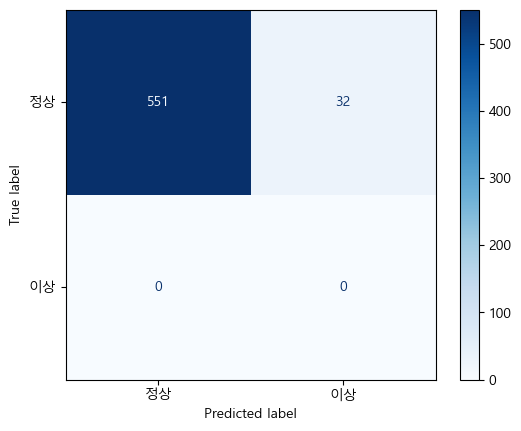

In [25]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

# 데이터 정규화
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# 정상 데이터만 선택 (anomaly 컬럼이 0인 데이터)
X_train_scaled = X_train_sc[y_train == 0]
X_test_scaled = X_test_sc

# One-Class SVM 학습
ocsvm = OneClassSVM(kernel='rbf', nu=0.01, gamma='scale', degree=3)
ocsvm.fit(X_train_scaled)

# 전체 데이터에 대한 예측 (-1: 이상치, 1: 정상치)
y_pred = ocsvm.predict(X_train_sc)
y_pred = [0 if pred == 1 else 1 for pred in y_pred]  # -1, 1 값을 1, 0으로 변환

# 성능 평가
verification_train(y_train, y_pred)

- AutoEncoder

In [53]:
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model

n_features = X_train.shape[1]
latent_dim = 6  # 더 높은 latent_dim을 사용하여 더 많은 정보 압축

# 인코더
enc_inputs = layers.Input(shape=(n_features,))
x = layers.Dense(32, activation='relu')(enc_inputs)
# x = layers.BatchNormalization()(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dense(8, activation='relu')(x)
x = layers.Dense(6, activation='relu')(x)
enc_outputs = layers.Dense(latent_dim, activation='relu')(x) # Latent vector

encoder = Model(inputs=enc_inputs, outputs=enc_outputs)

# 디코더
dec_inputs = layers.Input(shape=(latent_dim,)) # Latent vector
x = layers.Dense(6, activation='relu')(dec_inputs)
x = layers.Dense(8, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)
# x = layers.BatchNormalization()(x)
x = layers.Dense(32, activation='relu')(x)
dec_outputs = layers.Dense(n_features, activation='linear')(x) # 데이터를 보고 거기에 맞춰서 활성화 함수 사용 

decoder = Model(inputs=dec_inputs, outputs=dec_outputs)

# 오토인코더
inputs = layers.Input(shape=(n_features,))
latent = encoder(inputs)
outputs = decoder(latent)

AE = Model(inputs=inputs, outputs=outputs)
AE.compile(optimizer='adam', loss='mse', metrics='acc') # 오차 구하는 것 중에 미분이 잘 되는 것 mse
AE.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 9)]               0         
                                                                 
 model_21 (Functional)       (None, 6)                 1080      
                                                                 
 model_22 (Functional)       (None, 9)                 1083      
                                                                 
Total params: 2163 (8.45 KB)
Trainable params: 2163 (8.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
# n_features = X_train.shape[1]
# latent_dim = 3  

# # 인코더
# enc_inputs = layers.Input(shape=(n_features,))
# x = layers.Dense(32, activation='relu')(enc_inputs)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)

# x = layers.Dense(16, activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)

# x = layers.Dense(16, activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)

# x = layers.Dense(8, activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)

# x = layers.Dense(8, activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)

# x = layers.Dense(6, activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)

# x = layers.Dense(6, activation='relu')(x)  # 더 깊은 층 추가
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)

# x = layers.Dense(3, activation='relu')(x)  # 더 깊은 층 추가
# enc_outputs = layers.Dense(latent_dim, activation='relu')(x)

# encoder = Model(inputs=enc_inputs, outputs=enc_outputs)

# # 디코더
# dec_inputs = layers.Input(shape=(latent_dim,))
# x = layers.Dense(3, activation='relu')(dec_inputs)  # 더 깊은 층 추가
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)

# x = layers.Dense(6, activation='relu')(x)  # 더 깊은 층 추가
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)

# x = layers.Dense(6, activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)

# x = layers.Dense(8, activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)

# x = layers.Dense(8, activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)

# x = layers.Dense(16, activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)

# x = layers.Dense(16, activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)

# x = layers.Dense(32, activation='relu')(x)
# dec_outputs = layers.Dense(n_features, activation='linear')(x)
# decoder = Model(inputs=dec_inputs, outputs=dec_outputs)

# # 오토인코더
# inputs = layers.Input(shape=(n_features,))
# latent = encoder(inputs)
# outputs = decoder(latent)

# AE = Model(inputs=inputs, outputs=outputs)
# AE.compile(optimizer='adam', loss='mse', metrics='acc')
# AE.summary()


In [55]:
# from keras.layers import LeakyReLU, Dropout, ReLU
# from keras.models import Model
# from keras import layers

# n_features = X_train.shape[1]
# latent_dim = 4

# # 인코더
# enc_inputs = layers.Input(shape=(n_features,))
# x = layers.Dense(16)(enc_inputs)
# x = ReLU()(x)
# x = layers.Dense(16)(x)
# x = ReLU()(x)
# x = layers.Dense(16)(x)
# x = layers.BatchNormalization()(x)
# x = ReLU()(x)
# x = layers.Dropout(0.4)(x)

# x = layers.Dense(16)(x)
# x = ReLU()(x)
# x = layers.Dense(16)(x)
# x = ReLU()(x)
# x = layers.Dense(16)(x)
# x = layers.BatchNormalization()(x)
# x = ReLU()(x)

# x = layers.Dense(12)(x)
# x = ReLU()(x)
# x = layers.Dense(12)(x)
# x = ReLU()(x)
# x = layers.Dense(12)(x)
# x = layers.BatchNormalization()(x)
# x = ReLU()(x)
# x = layers.Dropout(0.4)(x)

# x = layers.Dense(12)(x)
# x = ReLU()(x)
# x = layers.Dense(12)(x)
# x = ReLU()(x)
# x = layers.Dense(12)(x)
# x = layers.BatchNormalization()(x)
# x = ReLU()(x)
# # x = layers.Dropout(0.4)(x)

# x = layers.Dense(8)(x)
# x = ReLU()(x)
# x = layers.Dense(8)(x)
# x = ReLU()(x)
# x = layers.Dense(8)(x)
# x = layers.BatchNormalization()(x)
# x = ReLU()(x)
# x = layers.Dropout(0.4)(x)

# x = layers.Dense(8)(x)
# x = ReLU()(x)
# x = layers.Dense(8)(x)
# x = ReLU()(x)
# x = layers.Dense(8)(x)
# x = layers.BatchNormalization()(x)
# x = ReLU()(x)
# # x = layers.Dropout(0.4)(x)

# x = layers.Dense(4)(x)
# x = ReLU()(x)
# x = layers.Dense(4)(x)
# x = ReLU()(x)
# x = layers.Dense(4)(x)
# x = ReLU()(x)

# enc_outputs = layers.Dense(latent_dim)(x)

# encoder = Model(inputs=enc_inputs, outputs=enc_outputs)

# # 디코더
# dec_inputs = layers.Input(shape=(latent_dim,))
# x = layers.Dense(4)(dec_inputs)
# x = ReLU()(x)
# x = layers.Dense(4)(x)
# x = ReLU()(x)
# x = layers.Dense(4)(x)
# x = layers.BatchNormalization()(x)
# x = ReLU()(x)
# # x = layers.Dropout(0.4)(x)

# x = layers.Dense(8)(x)
# x = ReLU()(x)
# x = layers.Dense(8)(x)
# x = ReLU()(x)
# x = layers.Dense(8)(x)
# x = layers.BatchNormalization()(x)
# x = ReLU()(x)
# x = layers.Dropout(0.4)(x)

# x = layers.Dense(8)(x)
# x = ReLU()(x)
# x = layers.Dense(8)(x)
# x = ReLU()(x)
# x = layers.Dense(8)(x)
# x = layers.BatchNormalization()(x)
# x = ReLU()(x)
# # x = layers.Dropout(0.4)(x)

# x = layers.Dense(12)(x)
# x = ReLU()(x)
# x = layers.Dense(12)(x)
# x = ReLU()(x)
# x = layers.Dense(12)(x)
# x = layers.BatchNormalization()(x)
# x = ReLU()(x)
# x = layers.Dropout(0.4)(x)

# x = layers.Dense(12)(x)
# x = ReLU()(x)
# x = layers.Dense(12)(x)
# x = ReLU()(x)
# x = layers.Dense(12)(x)
# x = layers.BatchNormalization()(x)
# x = ReLU()(x)
# # x = layers.Dropout(0.4)(x)

# x = layers.Dense(16)(x)
# x = ReLU()(x)
# x = layers.Dense(16)(x)
# x = ReLU()(x)
# x = layers.Dense(16)(x)
# x = layers.BatchNormalization()(x)
# x = ReLU()(x)
# x = layers.Dropout(0.4)(x)

# x = layers.Dense(16)(x)
# x = ReLU()(x)
# x = layers.Dense(16)(x)
# x = ReLU()(x)
# x = layers.Dense(16)(x)
# x = ReLU()(x)

# dec_outputs = layers.Dense(n_features, activation='linear')(x)
# decoder = Model(inputs=dec_inputs, outputs=dec_outputs)

# # 오토인코더
# inputs = layers.Input(shape=(n_features,))
# latent = encoder(inputs)
# outputs = decoder(latent)

# AE = Model(inputs=inputs, outputs=outputs)
# AE.compile(optimizer='adam', loss='mse', metrics='acc')
# AE.summary()

In [62]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)

history = AE.fit(X_train, X_train, validation_split=0.2, batch_size=128, epochs=2000, callbacks=[early_stopping]) # 압축 후 복원하기 때문에, 자신과 비교

Epoch 1/2000
4/4 [==============================] - 0s 21ms/step - loss: 0.0841 - acc: 1.0000 - val_loss: 0.1248 - val_acc: 1.0000
Epoch 2/2000
4/4 [==============================] - 0s 10ms/step - loss: 0.1066 - acc: 1.0000 - val_loss: 0.0670 - val_acc: 1.0000
Epoch 3/2000
4/4 [==============================] - 0s 8ms/step - loss: 0.0647 - acc: 1.0000 - val_loss: 0.0772 - val_acc: 1.0000
Epoch 4/2000
4/4 [==============================] - 0s 9ms/step - loss: 0.0657 - acc: 1.0000 - val_loss: 0.1023 - val_acc: 1.0000
Epoch 5/2000
4/4 [==============================] - 0s 8ms/step - loss: 0.1118 - acc: 1.0000 - val_loss: 0.0906 - val_acc: 1.0000
Epoch 6/2000
4/4 [==============================] - 0s 9ms/step - loss: 0.0808 - acc: 1.0000 - val_loss: 0.1791 - val_acc: 1.0000
Epoch 7/2000
4/4 [==============================] - 0s 8ms/step - loss: 0.1414 - acc: 1.0000 - val_loss: 0.0678 - val_acc: 1.0000
Epoch 8/2000
4/4 [==============================] - 0s 8ms/step - loss: 0.0646 - acc: 1.

In [63]:
p_test = AE.predict(X_test)
p_test.shape

15/15 [==============================] - 0s 717us/step


(479, 9)

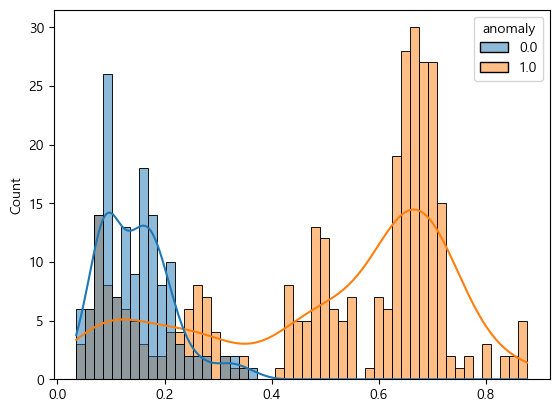

In [64]:
# 재건에러
def reconstruction_error(x, p):
    return np.mean(np.abs(x - p), axis=1)

rce = reconstruction_error(X_test, p_test)

plt.figure()
sns.histplot(x=rce, hue=y_test, bins=50, kde=True)
plt.show()

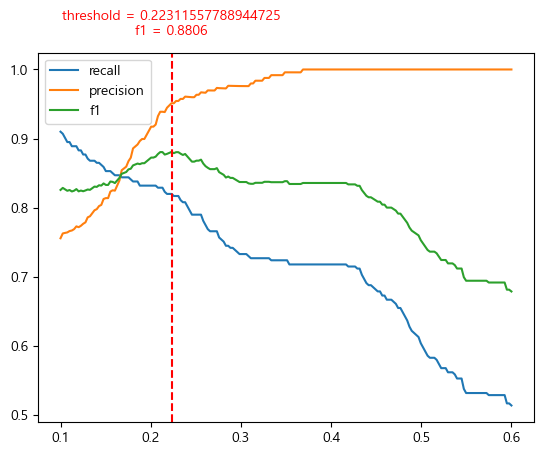

15/15 [==============================] - 0s 786us/step
Train Accuracy  :  0.7995824634655533
f1 score        :  0.8350515463917526
Recall Score    :  0.7297297297297297
precision score :  0.9759036144578314
confusion matrix : ------------------
 [[140   6]
 [ 90 243]]

         --------- Test Classification Report --------
              precision    recall  f1-score   support

         0.0       0.61      0.96      0.74       146
         1.0       0.98      0.73      0.84       333

    accuracy                           0.80       479
   macro avg       0.79      0.84      0.79       479
weighted avg       0.86      0.80      0.81       479



<Figure size 640x480 with 0 Axes>

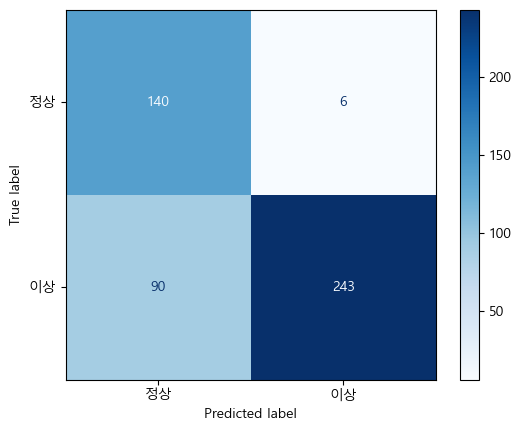

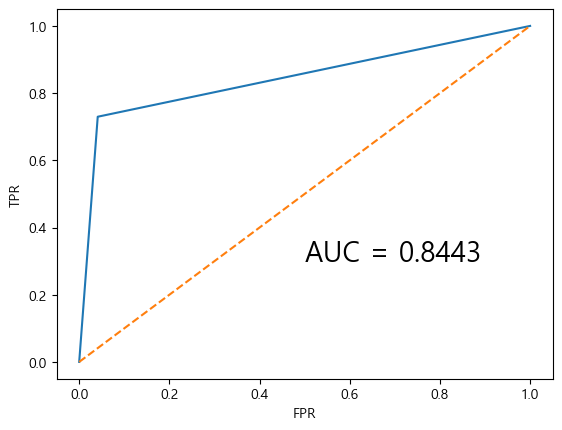

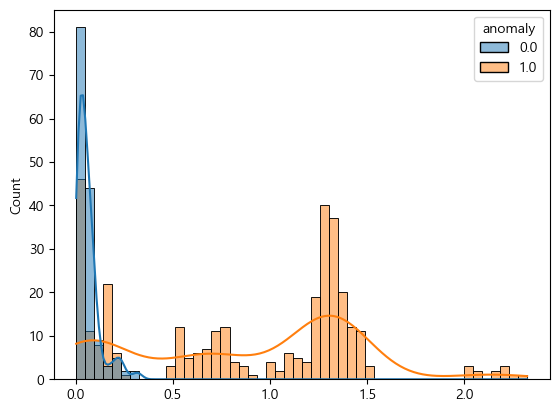

In [66]:
recall = []
precision = []
f1 = []

thresholds = np.linspace(0.1, 0.6, 200)
# thresholds = np.arange(0 1, 0.01)
for thres in thresholds:
    results = rce > thres
    recall.append(recall_score(y_test, results))
    precision.append(precision_score(y_test, results))
    f1.append(f1_score(y_test, results))


plt.figure()
plt.plot(thresholds, recall, label='recall')
plt.plot(thresholds, precision, label='precision')
plt.plot(thresholds, f1, label='f1')

plt.axvline(thresholds[np.argmax(f1)], color='red', linestyle='--')
plt.text(thresholds[np.argmax(f1)], 1.05, 'threshold = {}\nf1 = {:.4f}'.format(thresholds[np.argmax(f1)], np.max(f1)),
         color='red', horizontalalignment='center')

plt.legend()
plt.show()

# 오토인코더의 재구성 오차 계산
reconstruction_errors = np.mean(np.square(X_test - AE.predict(X_test)), axis=1)

# 이상치 여부 판단 (threshold 이상이면 이상치)
threshold = 0.22  # 임계치 설정

predicted_outliers = reconstruction_errors > threshold

# 검증 데이터의 실제 이상치 여부
actual_outliers = y_test

verification_test(actual_outliers, predicted_outliers)

plt.figure()
sns.histplot(x=reconstruction_errors, hue=y_test, bins=50, kde=True, color="coral")
plt.show()


### Scoring 기반 Threshold 조정
---
- IsolationForest에는 decision_function()이라는 스코어를 보여주는 것이 있습니다. 이를 활용해보세요.
- 분포시각화를 통해 Threshold 조정 해보세요. 스코어기반 threshold를 변경한 후 성능평가 해보세요
- sklearn.metrics의 classification_report() 활용

- Isolation Forest

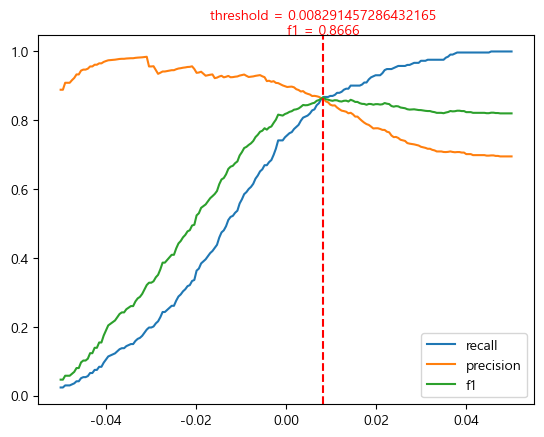

In [32]:
decision_scores = model.decision_function(X_test)

recall = []
precision = []
f1 = []

thresholds = np.linspace(-0.05, 0.05, 200)  # 임계값 범위를 조정합니다.
for thres in thresholds:
    results = [1 if score <= thres else 0 for score in decision_scores]  # 이상치 판단 기준
    recall.append(recall_score(y_test, results))
    precision.append(precision_score(y_test, results))
    f1.append(f1_score(y_test, results))

plt.figure()
plt.plot(thresholds, recall, label='recall')
plt.plot(thresholds, precision, label='precision')
plt.plot(thresholds, f1, label='f1')

plt.axvline(thresholds[np.argmax(f1)], color='red', linestyle='--')
plt.text(thresholds[np.argmax(f1)], 1.05, 'threshold = {}\nf1 = {:.4f}'.format(thresholds[np.argmax(f1)], np.max(f1)),
         color='red', horizontalalignment='center')

plt.legend()
plt.show()


Train Accuracy  :  0.8100208768267223
f1 score        :  0.8631578947368421
Recall Score    :  0.8618618618618619
precision score :  0.8644578313253012
confusion matrix : ------------------
 [[101  45]
 [ 46 287]]

         --------- Test Classification Report --------
              precision    recall  f1-score   support

         0.0       0.69      0.69      0.69       146
         1.0       0.86      0.86      0.86       333

    accuracy                           0.81       479
   macro avg       0.78      0.78      0.78       479
weighted avg       0.81      0.81      0.81       479



<Figure size 640x480 with 0 Axes>

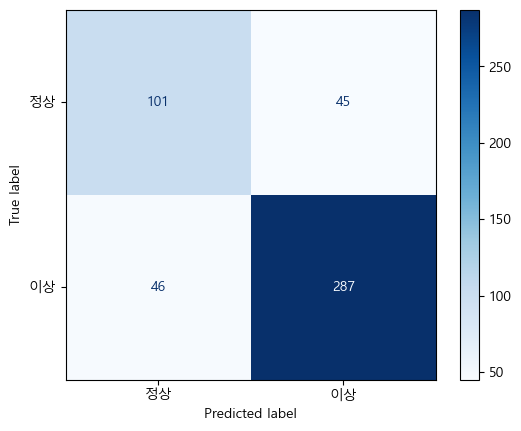

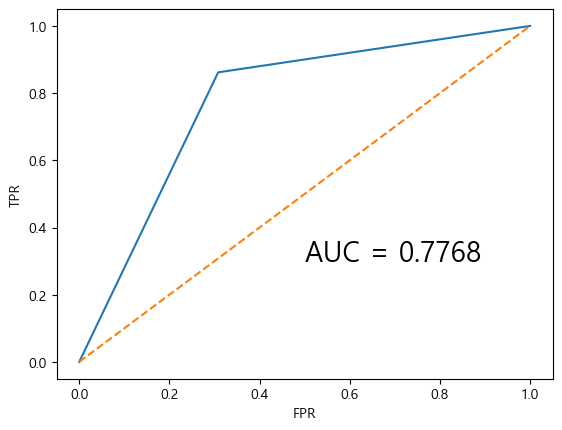

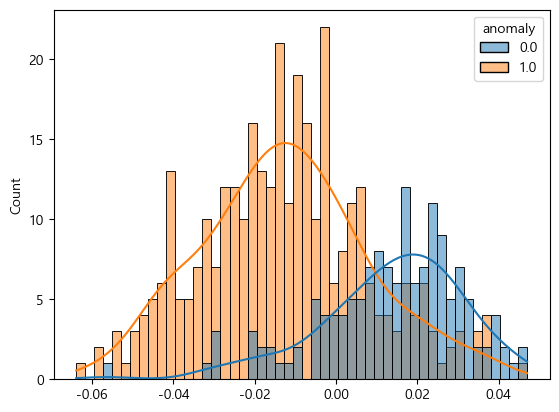

In [33]:
# 검증 데이터에 대한 이상치 점수 계산
decision_scores = model.decision_function(X_test)

# 이상치 점수를 바탕으로 이상치 임계치 설정 (예: 점수가 낮을수록 이상치로 간주) / 0 이 기본
threshold = 0.008

# 이상치 여부 판단 (1: 이상치, 0: 정상치)
predicted_outliers = [1 if score <= threshold else 0 for score in decision_scores]

verification_test(y_test, predicted_outliers)

# 이상치 점수 히스토그램
plt.figure()
sns.histplot(x=decision_scores, hue=y_test, bins=50, kde=True, color="coral")
plt.show()

- OC-SVM

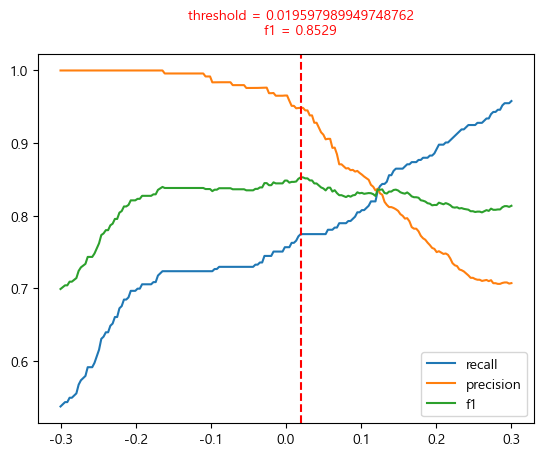

Train Accuracy  :  0.81419624217119
f1 score        :  0.8528925619834711
Recall Score    :  0.7747747747747747
precision score :  0.9485294117647058
confusion matrix : ------------------
 [[132  14]
 [ 75 258]]

         --------- Test Classification Report --------
              precision    recall  f1-score   support

         0.0       0.64      0.90      0.75       146
         1.0       0.95      0.77      0.85       333

    accuracy                           0.81       479
   macro avg       0.79      0.84      0.80       479
weighted avg       0.85      0.81      0.82       479



<Figure size 640x480 with 0 Axes>

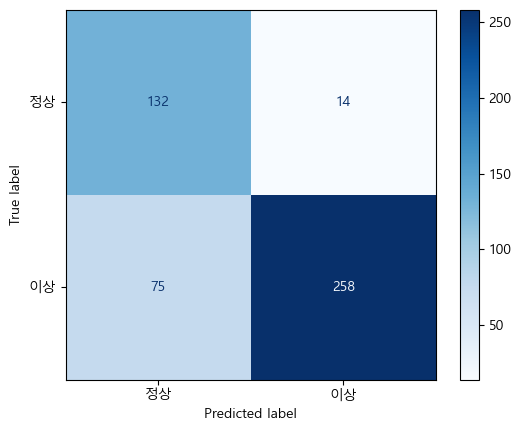

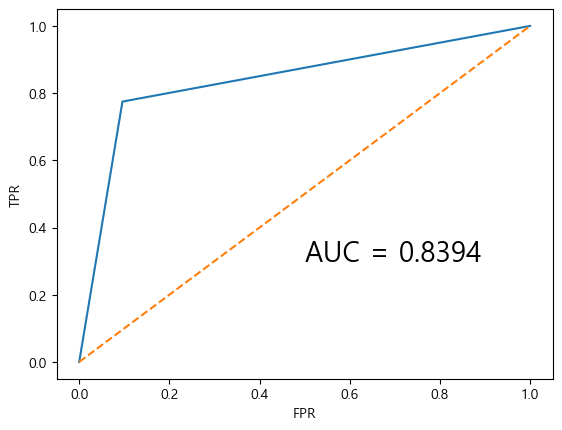

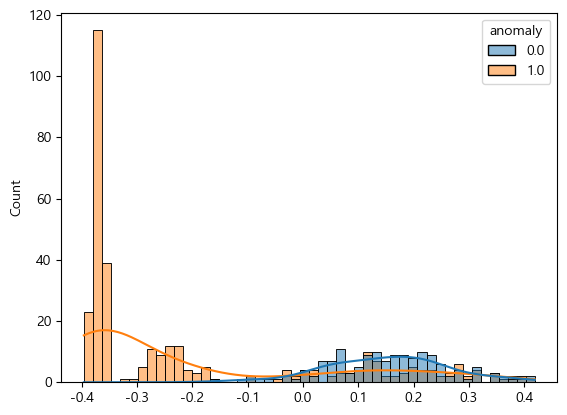

In [34]:
# OneClassSVM의 decision_function을 사용하여 검증 데이터의 점수를 계산합니다.
decision_scores = ocsvm.decision_function(X_test_scaled)

recall = []
precision = []
f1 = []

thresholds = np.linspace(-0.3, 0.3, 200)  # 임계값 범위를 조정합니다.
for thres in thresholds:
    results = [1 if score <= thres else 0 for score in decision_scores]  # 이상치 판단 기준
    recall.append(recall_score(y_test, results))
    precision.append(precision_score(y_test, results))
    f1.append(f1_score(y_test, results))

plt.figure()
plt.plot(thresholds, recall, label='recall')
plt.plot(thresholds, precision, label='precision')
plt.plot(thresholds, f1, label='f1')

plt.axvline(thresholds[np.argmax(f1)], color='red', linestyle='--')
plt.text(thresholds[np.argmax(f1)], 1.05, 'threshold = {}\nf1 = {:.4f}'.format(thresholds[np.argmax(f1)], np.max(f1)),
         color='red', horizontalalignment='center')

plt.legend()
plt.show()

# 검증 데이터에 대한 이상치 점수 계산
decision_scores = ocsvm.decision_function(X_test_scaled)

# 이상치 점수를 바탕으로 이상치 임계치 설정 (예: 점수가 낮을수록 이상치로 간주)
threshold = 0.019

# 이상치 여부 판단 (1: 이상치, 0: 정상치)
predicted_outliers = [1 if score <= threshold else 0 for score in decision_scores]

verification_test(y_test, predicted_outliers)

# 이상치 점수 히스토그램
plt.figure()
sns.histplot(x=decision_scores,  hue=y_test,bins=50, kde=True, color="coral")
plt.show()